In [1]:
import sympy as sym
import numpy as np
import pandas as pd

In [2]:
# define symbols
t = sym.Symbol('t')

I = sym.Symbol('I')
m = sym.Symbol('m')
m_inf = sym.Symbol('m_inf')

p = sym.Symbol('p')

prestep_V = sym.Symbol('prestep_V')
step_V = sym.Symbol('step_V')

g_max = sym.Symbol('g_max')
E_rev = sym.Symbol('E_rev')
a_m = sym.Symbol('a_m')
b_m = sym.Symbol('b_m')
delta_m = sym.Symbol('delta_m')
s_m = sym.Symbol('s_m')

In [3]:
V_2m = -s_m * sym.log(b_m / a_m)
tau_0m = 1/a_m * sym.exp(delta_m * V_2m / s_m)
m_infty = 1 / (1 + sym.exp((step_V - V_2m) / s_m))
tau_m = (tau_0m * sym.exp(delta_m * ((step_V - V_2m) / s_m))) / (1 + sym.exp((step_V - V_2m) / s_m))
m_0 = 1 / (1 + sym.exp((prestep_V - V_2m) / s_m))

m = m_infty + (m_0 - m_infty) * sym.exp(-t/tau_m)
I = g_max * m ** p * (step_V - E_rev)

In [4]:
diff_I_p = sym.diff(I, p)
diff_I_g_max = sym.diff(I, g_max)
diff_I_E_rev = sym.diff(I, E_rev)
diff_I_a_m = sym.diff(I, a_m)
diff_I_b_m = sym.diff(I, b_m)
diff_I_delta_m = sym.diff(I, delta_m)
diff_I_s_m = sym.diff(I, s_m)

In [5]:
# Create a function from the differentiated expression
func_diff_I_p = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_p, "numpy")
func_diff_I_g_max = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_g_max, "numpy")
func_diff_I_E_rev = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_E_rev, "numpy")
func_diff_I_a_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_a_m, "numpy")
func_diff_I_b_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_b_m, "numpy")
func_diff_I_delta_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_delta_m, "numpy")
func_diff_I_s_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_s_m, "numpy")
diff_functions = [func_diff_I_p, func_diff_I_g_max, func_diff_I_E_rev, func_diff_I_a_m, func_diff_I_b_m, func_diff_I_delta_m, func_diff_I_s_m]

#### Read test dataset

In [6]:
from dataset_reader import Traces_Dataset
# load and process dataset 
dataset = Traces_Dataset('dataset_exp_test.csv')

In [7]:
dataset.time_traces.shape, dataset.current_traces.shape, dataset.params.shape

(torch.Size([1000, 11, 20]), torch.Size([1000, 11, 20]), torch.Size([1000, 7]))

In [8]:
sample = 1
len_params = 7 # dont need, same indexing time 
params = dataset.params[sample].numpy()
t_traces = dataset.time_traces[sample].numpy()
current_traces = dataset.current_traces[sample].numpy()
prestep_V = dataset.prestep_V[sample].numpy()
step_Vs = np.arange(dataset.step_V1[sample], dataset.step_V1[sample]+11*10, 10)

In [9]:
t_pts_col = t_traces.T.reshape(-1)
step_Vs_col = np.tile(step_Vs, 20)

In [10]:
# Initialize an empty list to store the sens_co_matrix_col arrays
sens_co_matrix_col_list = []

for p in range(len_params): 
    sens_co_matrix_col = diff_functions[p](t_pts_col, prestep_V, step_Vs_col, params[0], params[1], params[2], params[3], params[4], params[5], params[6])
    sens_co_matrix_col_list.append(sens_co_matrix_col)

# Concatenate all arrays horizontally
# stacked_matrix = np.hstack(sens_co_matrix_col_list)
sens_co_matrix = np.array(sens_co_matrix_col_list).T
sens_co_matrix.shape

(220, 7)

In [11]:
sens_co_matrices = np.stack([sens_co_matrix+1, sens_co_matrix], axis=0)

In [181]:
sens_co_matrices_list = []
P_matrices_list = []
Y_matrices_list = []
for sample in range(dataset.__len__()): 
    # len_params = 7 # dont need, same indexing time 
    params = dataset.params[sample].numpy()
    t_traces = dataset.time_traces[sample].numpy()
    current_traces = dataset.current_traces[sample].numpy()
    prestep_V = dataset.prestep_V[sample].numpy()
    step_Vs = np.arange(dataset.step_V1[sample], dataset.step_V1[sample]+dataset.num_traces*10, 10)

    t_pts_col = t_traces.T.reshape(-1)
    step_Vs_col = np.tile(step_Vs, dataset.num_pts)

    # Initialize an empty list to store the sens_co_matrix_col arrays
    sens_co_matrix_col_list = []
    
    for p in range(dataset.num_params): 
        sens_co_matrix_col = diff_functions[p](t_pts_col, prestep_V, step_Vs_col, params[0], params[1], params[2], params[3], params[4], params[5], params[6])
        sens_co_matrix_col_list.append(sens_co_matrix_col)
    
    sens_co_matrix = np.array(sens_co_matrix_col_list).T
    sens_co_matrices_list.append(sens_co_matrix)

    # find the parameter matrix P, and observable matrix Y
    P_matrix = np.tile(params, (dataset.num_traces * dataset.num_pts, 1))
    P_matrices_list.append(P_matrix)
    Y_col = dataset.current_traces[sample].numpy().T.reshape(-1,1)
    Y_matrix = np.tile(Y_col, (1, dataset.num_params))
    Y_matrices_list.append(Y_matrix)

# put lists in 3d numpy matrix
sens_co_matrices = np.stack(sens_co_matrices_list, axis=0)
P_matrices = np.stack(P_matrices_list, axis=0)
Y_matrices = np.stack(Y_matrices_list, axis=0)

sens_co_matrices.shape, P_matrices.shape, Y_matrices.shape

((1000, 220, 7), (1000, 220, 7), (1000, 220, 7))

In [182]:
relative_sens_co_matrices = (P_matrices / Y_matrices) * sens_co_matrices
relative_sens_co_matrices.shape

(1000, 220, 7)

In [183]:
# Calculate the 2-norm of each column in each matrix
norms = np.linalg.norm(relative_sens_co_matrices, axis=1)
# Find the index of the column with the largest 2-norm for each matrix
max_norm_indices = np.argmax(norms, axis=1)
max_norm_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### find R_2 (matrix operation)

In [137]:
S_tildes = relative_sens_co_matrices
X_1s = S_tildes[np.arange(S_tildes.shape[0]), :, max_norm_indices][:, :, np.newaxis]
S_tildes.shape, X_1s.shape

((1000, 220, 7), (1000, 220, 1))

In [138]:
R_2s = S_tildes - X_1s @ np.linalg.pinv(X_1s.transpose(0, 2, 1) @ X_1s) @ X_1s.transpose(0, 2, 1) @ S_tildes
R_2s.shape

(1000, 220, 7)

In [139]:
# Calculate the 2-norm of each column in each matrix
R_2_norms = np.linalg.norm(R_2s, axis=1)
# Find the index of the column with the largest 2-norm for each matrix
R_2_max_norm_indices = np.argmax(R_2_norms, axis=1)
R_2_max_norm_indices

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

#### Find R_3 (matrix operation)

In [152]:
X_1s.shape

(1000, 220, 1)

In [153]:
new_X1s = S_tildes[np.arange(S_tildes.shape[0]), :, R_2_max_norm_indices][:, :, np.newaxis]
new_X1s.shape

(1000, 220, 1)

In [145]:
X_2s = np.concatenate((X_1s, new_X1s), axis=2)
X_2s.shape

(1000, 220, 2)

In [146]:
R_3s = S_tildes - X_2s @ np.linalg.pinv(X_2s.transpose(0, 2, 1) @ X_2s) @ X_2s.transpose(0, 2, 1) @ S_tildes
R_3s.shape

(1000, 220, 7)

In [147]:
# Calculate the 2-norm of each column in each matrix
R_3_norms = np.linalg.norm(R_3s, axis=1)
# Find the index of the column with the largest 2-norm for each matrix
R_3_max_norm_indices = np.argmax(R_3_norms, axis=1)
R_3_max_norm_indices

array([1, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 1,
       5, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 5, 1,
       5, 1, 5, 5, 5, 3, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 1, 5, 5, 5,
       5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 1, 5,
       5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 1, 5, 5, 3, 5, 5, 5,
       5, 5, 5, 5, 4, 5, 5, 5, 1, 1, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 1, 5, 5, 5,

#### Iteratively finding all Rs, and ranks of params sensitivity across all samples

In [184]:
X_1s.shape

(1000, 220, 1)

In [185]:
a=[]
a.append(X_1s)
# a.append(new_X1s)
b = np.concatenate(a, axis=2)
b.shape

(1000, 220, 1)

In [186]:
S_tildes = relative_sens_co_matrices
X_s = S_tildes[np.arange(S_tildes.shape[0]), :, max_norm_indices][:, :, np.newaxis]
S_tildes.shape, X_1s.shape

((1000, 220, 7), (1000, 220, 1))

In [187]:
X_i_list = []
max_norm_indices_ranks = [max_norm_indices]
for i in range(dataset.num_params-1): 
    para_cols = S_tildes[np.arange(S_tildes.shape[0]), :, max_norm_indices][:, :, np.newaxis]
    X_i_list.append(para_cols)
    X_i = np.concatenate(X_i_list, axis=2)
    Rs = S_tildes - X_i @ np.linalg.pinv(X_i.transpose(0, 2, 1) @ X_i) @ X_i.transpose(0, 2, 1) @ S_tildes
    # Calculate the 2-norm of each column in each matrix
    R_norms = np.linalg.norm(Rs, axis=1)
    # Find the index of the column with the largest 2-norm for each matrix
    max_norm_indices = np.argmax(R_norms, axis=1)
    max_norm_indices_ranks.append(max_norm_indices)

In [190]:
ranks_all_samples = np.stack(max_norm_indices_ranks, axis=1)
ranks_all_samples.shape

(1000, 7)

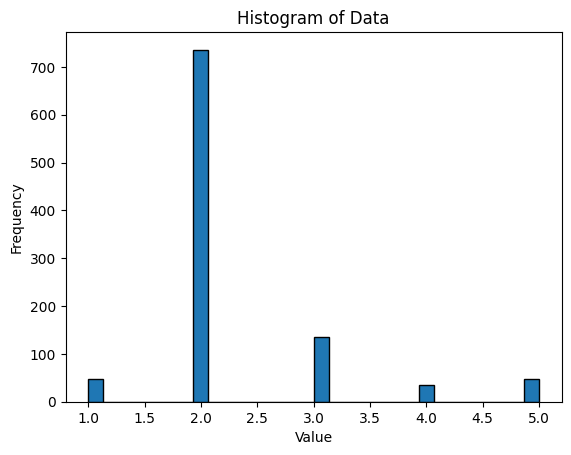

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data
data = ranks_all_samples[:, 6]

# Plot histogram
plt.hist(data, bins=30, edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
